Final capstone: David López Companys

# Introduction

The main goal for this project is to find the optimal location for luxury supermarket store in Barcelona. For that, the population immigration and existence of similar other services by district will be analised.

At the and, we need to be able to provide a recomendation of in wich districts is more feasable to open that type of superarket.

For this project, the data that will be used to analyse the venues comes from the Foursquare API and the Barcelona's City Hall. 

### Import libraries

In [1]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


### Import dataset

In [68]:
df = pd.read_csv('bcn_immigrants.csv')
df.fillna(method = 'ffill', inplace = True)
df.fillna(method = 'bfill', inplace = True)
df.head()

,Unnamed: 0,Ciutat Vella,Eixample,Gracia,Horta-Guinardó,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi
0,Andalusia,223,476,187,180,89,204,125,302,290,125
1,Aragó,69,167,49,64,54,57,52,84,103,43
2,Canaries,106,181,60,65,28,69,38,103,104,70
3,Cantabria,19,32,17,12,5,11,22,13,27,8
4,Castella - la Manxa,49,77,26,36,20,39,40,71,43,20


In [66]:
df= df.groupby(['Lloc_de_procedencia','Nom_districte']).sum()
print(len(df))
df.head()
df.to_csv('bcn_immigran_grouped.csv')

KeyError: 'Lloc_de_procedencia'

### Create dataset with district coordinates and city coordinates

In [71]:
coordinates_df = pd.DataFrame( data = {

'Neighborhood' : ['Ciutat Vella', 'Eixample', 'Gracia', 'Horta-Guinardó', 'Les Corts',
                'Nou Barris', 'Sant Andreu', 'Sant Marti', 'Sants-Montjuic', 'Sarria-Sant Gervasi'],
'Latitude' : ['41.382701', '41.390581', '41.402645', '41.425951', '41.383676', '41.442095', '41.434689', '41.408893', '41.370656',
                 '41.403014'],
'Longitude' : ['2.177693', '2.162539', '2.157367', '2.157274', '2.117135', '2.174900', '2.193739', '2.201876', '2.142874', 
                  '2.129702']})

coordinates_df['Latitude'] = coordinates_df['Latitude'].astype('float', errors = 'ignore')
coordinates_df['Longitude'] = coordinates_df['Longitude'].astype('float', errors = 'ignore')
coordinates_df.dtypes

address = 'Barcelona, Barcelona'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Barcelona are {}, {}.'.format(latitude, longitude))

C:\Users\dlope\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinates of Barcelona are 41.3828939, 2.1774322.


### Plot map of Barcelona with its districts

In [77]:
Barcelona_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7).add_to(Barcelona_map)  

In [78]:
Barcelona_map

### Get venues by district from Foursquare

In [79]:
CLIENT_ID = '0YF3VTAOIVL3TO04WKDMS5LQICACVPTPDXSULHCTRVVMFWIG' # Foursquare ID
CLIENT_SECRET = 'AKNOV1PUUBJVWSO5AVOPCX4EHBXVKINOC444IAXPKB0N12NZ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 0YF3VTAOIVL3TO04WKDMS5LQICACVPTPDXSULHCTRVVMFWIG
CLIENT_SECRET:AKNOV1PUUBJVWSO5AVOPCX4EHBXVKINOC444IAXPKB0N12NZ


In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Barcelona_venues = getNearbyVenues(names= coordinates_df['Neighborhood'],
                                   latitudes= coordinates_df['Latitude'],
                                   longitudes= coordinates_df['Longitude']
                                  )

Ciutat Vella
Eixample
Gracia
Horta-Guinardó
Les Corts
Nou Barris
Sant Andreu
Sant Marti
Sants-Montjuic
Sarria-Sant Gervasi


In [84]:
# one hot encoding
bcn_onehot = pd.get_dummies(Barcelona_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bcn_onehot['Neighborhood'] = Barcelona_venues['Neighborhood'] 

bcn_onehot.head()

bcn_grouped = bcn_onehot.groupby('Neighborhood').mean().reset_index()
bcn_grouped

,Neighborhood,Accessories Store,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,Bakery,Bar,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hockey Arena,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lounge,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Miscellaneous Shop,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pizza Place,Plaza,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Toy / Game Store,Tram Station,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Wine Bar,Wine Shop,Women's Store
0,Ciutat Vella,0.00,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.01,0.010000,0.070000,0.00,0.00,0.00,0.010000,0.000000,0.00,0.00,0.000000,0.010000,0.01,0.000000,0.010000,0.020000,0.01,0.010000,0.000000,0.00,0.00,0.04,0.030000,0.00,0.01,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.020000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.01,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.00,0.000000,0.040000,0.01,0.04,0.00,0.020000,0.010000,0.01,0.00,0.000000,0.00,0.00,0.020000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.01,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.080000,0.00,0.00,0.000000,0.01,0.00,0.020000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.01,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.00,0.060000,0.00,0.000000,0.01,0.000000,0.000000,0.000000,0.090000,0.03,0.000000,0.000000,0.00,0.000000,0.04,0.00,0.00,0.050000,0.01,0.01
1,Eixample,0.01,0.010000,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.030000,0.020000,0.00,0.01,0.00,0.010000,0.030000,0.05,0.00,0.010000,0.000000,0.00,0.000000,0.020000,0.010000,0.00,0.000000,0.010000,0.02,0.04,0.03,0.010000,0.00,0.00,0.000000,0.020000,0.000000,0.01,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.02,0.000000,0.000000,0.000000,0.01,0.000000,0.00,0.01,0.000000,0.030000,0.010000,0.000000,0.000000,0.00,0.00,0.030000,0.100000,0.01,0.01,0.00,0.000000,0.030000,0.00,0.00,0.000000,0.01,0.01,0.040000,0.000000,0.00,0.01,0.01,0.010000,0.01,0.00,0.000000,0.01,0.000000,0.010000,0.000000,0.01,0.000000,0.010000,0.000000,0.010000,0.00,0.00,0.000000,0.01,0.00,0.010000,0.00,0.02,0.01,0.01,0.01,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.01,0.020000,0.00,0.000000,0.00,0.000000,0.000000,0.010000,0.060000,0.00,0.000000,0.000000,0.00,0.000000,0.01,0.00,0.01,0.010000,0.00,0.01
2,Gracia,0.00,0.000000,0.00,0.03,0.030000,0.000000,0.000000,0.00,0

In [31]:
num_top_venues = 5

for hood in bcn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bcn_grouped[bcn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ciutat Vella----
                venue  freq
0    Tapas Restaurant  0.09
1               Plaza  0.08
2                 Bar  0.07
3  Spanish Restaurant  0.06
4            Wine Bar  0.05


----Eixample----
                      venue  freq
0                     Hotel  0.10
1          Tapas Restaurant  0.06
2                  Boutique  0.05
3  Mediterranean Restaurant  0.04
4            Clothing Store  0.04


----Gracia----
              venue  freq
0  Tapas Restaurant  0.08
1      Cocktail Bar  0.07
2               Bar  0.07
3             Plaza  0.05
4    Ice Cream Shop  0.05


----Horta-Guinardó----
                      venue  freq
0        Chinese Restaurant  0.09
1                Food Court  0.09
2         Food & Drink Shop  0.09
3                     Plaza  0.09
4  Mediterranean Restaurant  0.09


----Les Corts----
                 venue  freq
0         Soccer Field  0.12
1         Tram Station  0.12
2            Nightclub  0.08
3                 Café  0.04
4  Sporting Goods Sho

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bcn_grouped['Neighborhood']

for ind in np.arange(bcn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bcn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciutat Vella,Tapas Restaurant,Plaza,Bar,Spanish Restaurant,Wine Bar,Hotel,Cocktail Bar,Vegetarian / Vegan Restaurant,Ice Cream Shop,Tea Room
1,Eixample,Hotel,Tapas Restaurant,Boutique,Clothing Store,Mediterranean Restaurant,Hostel,Japanese Restaurant,Cocktail Bar,Gym,Bookstore
2,Gracia,Tapas Restaurant,Cocktail Bar,Bar,Café,Plaza,Pizza Place,Ice Cream Shop,Restaurant,Mediterranean Restaurant,Arts & Crafts Store
3,Horta-Guinardó,Supermarket,Food & Drink Shop,Plaza,Gym,Grocery Store,Food Court,Café,Coffee Shop,Metro Station,Chinese Restaurant
4,Les Corts,Tram Station,Soccer Field,Nightclub,Gym,Garden,Print Shop,College Cafeteria,Donut Shop,Museum,Science Museum
5,Nou Barris,Spanish Restaurant,Grocery Store,Plaza,Park,Diner,Building,Seafood Restaurant,Metro Station,Brewery,Skate Park
6,Sant Andreu,Spanish Restaurant,Café,Supermarket,Restaurant,Tapas Restaurant,Park,Brewery,Plaza,Coffee Shop,Bar
7,Sant Marti,Hotel,Pizza Place,Supermarket,Park,Convenience Store,Office,Falafel Restaurant,Mediterranean Restaurant,Café,Kebab Restaurant
8,Sants-Montjuic,Spanish Restaurant,Restaurant,Grocery Store,Plaza,Hotel,Tapas Restaurant,Breakfast Spot,Burger Joint,Supermarket,Bakery
9,Sarria-Sant Gervasi,Bakery,Restaurant,Coffee Shop,Spanish Restaurant,Hotel,Seafood Restaurant,Bar,Café,Mediterranean Restaurant,Japanese Restaurant


### Let's cluster our districts

In [88]:
bcn_grouped_clustering = bcn_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(bcn_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [89]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k

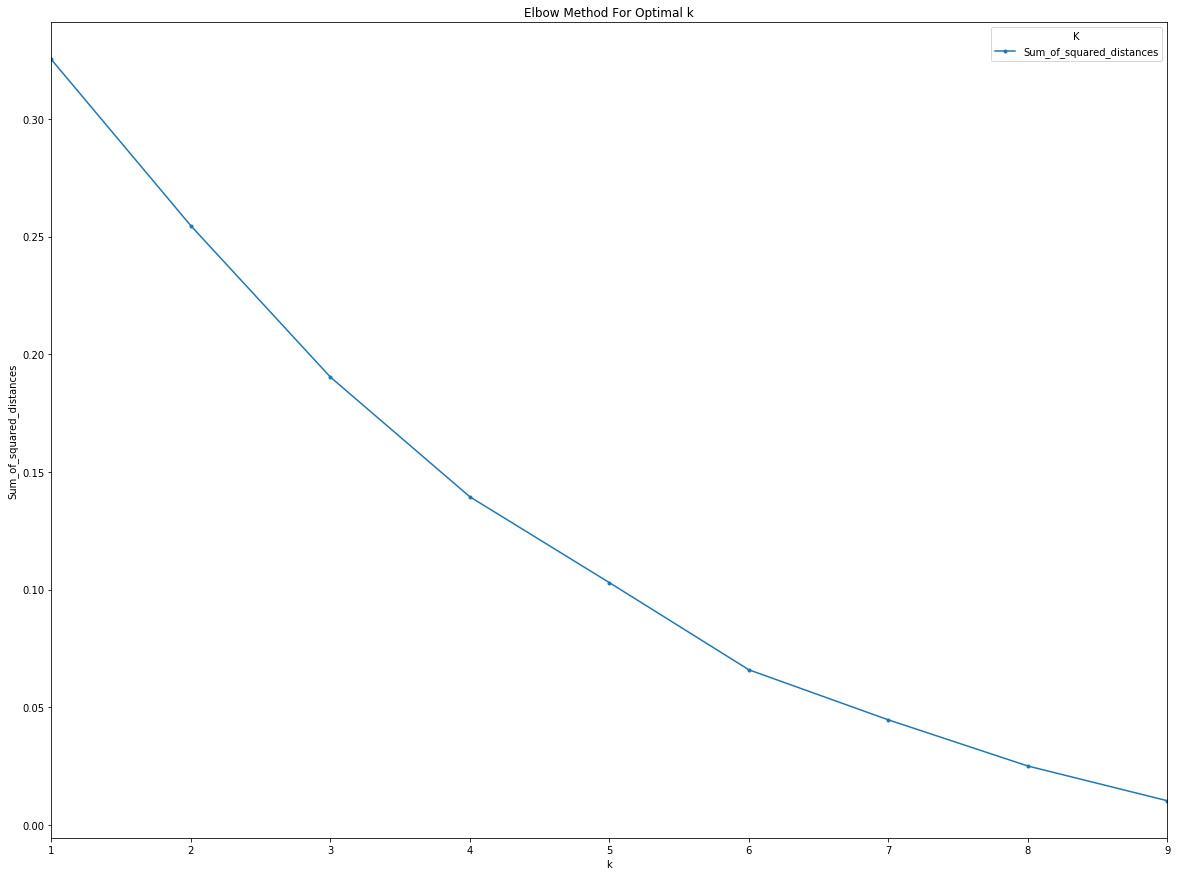

In [90]:
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Optimal number of clusters = 6

In [91]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bcn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 4, 2, 5, 1, 3, 1, 1])

In [92]:
df['Neighborhood'] = neighborhoods_venues_sorted['Neighborhood']
print(df.shape)
df.isnull().sum()
df.dropna(how = 'any', axis = 0, inplace = True)
print(df.shape)
print(neighborhoods_venues_sorted.shape)

(20, 12)
(10, 12)
(10, 11)


### Here our results!! Cluster labels with most common venoes and population distribution

In [96]:
bcn_merged = df

# add clustering labels
bcn_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bcn_merged = bcn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bcn_merged[['Latitude', 'Longitude']] = coordinates_df[['Latitude', 'Longitude']]
bcn_merged['Latitude'] = bcn_merged['Latitude'].astype(float)
bcn_merged['Longitude'] = bcn_merged['Longitude'].astype(float)
print(bcn_merged.shape)
bcn_merged # check the last columns!

(10, 25)


,Unnamed: 0,Ciutat Vella,Eixample,Gracia,Horta-Guinardó,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Andalusia,223,476,187,180,89,204,125,302,290,125,Ciutat Vella,0,Tapas Restaurant,Plaza,Bar,Spanish Restaurant,Wine Bar,Hotel,Cocktail Bar,Vegetarian / Vegan Restaurant,Ice Cream Shop,Tea Room,41.382701,2.177693
1,Aragó,69,167,49,64,54,57,52,84,103,43,Eixample,0,Hotel,Tapas Restaurant,Boutique,Clothing Store,Mediterranean Restaurant,Hostel,Japanese Restaurant,Cocktail Bar,Gym,Bookstore,41.390581,2.162539
2,Canaries,106,181,60,65,28,69,38,103,104,70,Gracia,0,Tapas Restaurant,Cocktail Bar,Bar,Café,Plaza,Pizza Place,Ice Cream Shop,Restaurant,Mediterranean Restaurant,Arts & Crafts Store,41.402645,2.157367
3,Cantabria,19,32,17,12,5,11,22,13,27,8,Horta-Guinardó,4,Supermarket,Food & Drink Shop,Plaza,Gym,Grocery Store,Food Court,Café,Coffee Shop,Metro Station,Chinese Restaurant,41.425951,2.157274
4,Castella - la Manxa,49,77,26,36,20,39,40,71,43,20,Les Corts,2,Tram Station,Soccer Field,Nightclub,Gym,Garden,Print Shop,College Cafeteria,Donut Shop,Museum,Science Museum,41.383676,2.117135
5,Castella i Lleó,67,146,52,75,43,54,60,103,105,39,Nou Barris,5,Spanish Restaurant,Grocery Store,Plaza,Park,Diner,Building,Seafood Restaurant,Metro Station,Brewery,Skate Park,41.442095,2.174900
6,Catalunya,2619,4541,1960,2799,1579,3265,2639,3889,4214,2297,Sant Andreu,1,Spanish Restaurant,Café,Supermarket,Restaurant,Tapas Restaurant,Park,Brewery,Plaza,Coffee Shop,Bar,41.434689,2.193739
7,Ceuta,5,2,0,5,1,4,0,5,5,4,Sant Marti,3,Hotel,Pizza Place,Supermarket,Park,Convenience Store,Office,Falafel Restaurant,Mediterranean Restaurant,Café,Kebab Restaurant,41.408893,2.201876
8,Comunitat Foral de Navarra,15,59,18,20,12,16,20,25,24,29,Sants-Montjuic,1,Spanish Restaurant,Restaurant,Grocery Store,Plaza,Hotel,Tapas Restaurant,Breakfast Spot,Burger Joint,Supermarket,Bakery,41.370656,2.142874
9,Comunitat Valenciana,218,432,175,190,96,144,167,309,297,141,Sarria-Sant Gervasi,1,Bakery,Restaurant,Coffee Shop,Spanish Restaurant,Hotel,Seafood Restaurant,Bar,Café,Mediterranean Restaurant,Japanese Restaurant,41.403014,2.129702


In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bcn_merged['Latitude'], bcn_merged['Longitude'], bcn_merged['Neighborhood'], bcn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now, we can analise our clusters on by one

In [55]:
bcn_merged.loc[bcn_merged['Cluster Labels'] == 0 , bcn_merged.columns[[0] + list(range(5, bcn_merged.shape[1]))]].sort_values(by = ['Unnamed: 0'], ascending = False)

,Unnamed: 0,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
2,Canaries,28,69,38,103,104,70,Gracia,0,Tapas Restaurant,Cocktail Bar,Bar,Café,Plaza,Pizza Place,Ice Cream Shop,Restaurant,Mediterranean Restaurant,Arts & Crafts Store,41.402645,2.157367
1,Aragó,54,57,52,84,103,43,Eixample,0,Hotel,Tapas Restaurant,Boutique,Clothing Store,Mediterranean Restaurant,Hostel,Japanese Restaurant,Cocktail Bar,Gym,Bookstore,41.390581,2.162539
0,Andalusia,89,204,125,302,290,125,Ciutat Vella,0,Tapas Restaurant,Plaza,Bar,Spanish Restaurant,Wine Bar,Hotel,Cocktail Bar,Vegetarian / Vegan Restaurant,Ice Cream Shop,Tea Room,41.382701,2.177693


In [56]:
bcn_merged.loc[bcn_merged['Cluster Labels'] == 1 , bcn_merged.columns[[0] + list(range(5, bcn_merged.shape[1]))]].sort_values(by = ['Unnamed: 0'], ascending = False)

,Unnamed: 0,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
9,Comunitat Valenciana,96,144,167,309,297,141,Sarria-Sant Gervasi,1,Bakery,Restaurant,Coffee Shop,Spanish Restaurant,Hotel,Seafood Restaurant,Bar,Café,Mediterranean Restaurant,Japanese Restaurant,41.403014,2.129702
8,Comunitat Foral de Navarra,12,16,20,25,24,29,Sants-Montjuic,1,Spanish Restaurant,Restaurant,Grocery Store,Plaza,Hotel,Tapas Restaurant,Breakfast Spot,Burger Joint,Supermarket,Bakery,41.370656,2.142874
6,Catalunya,1579,3265,2639,3889,4214,2297,Sant Andreu,1,Spanish Restaurant,Café,Supermarket,Restaurant,Tapas Restaurant,Park,Brewery,Plaza,Coffee Shop,Bar,41.434689,2.193739


In [57]:
bcn_merged.loc[bcn_merged['Cluster Labels'] == 2 , bcn_merged.columns[[0] + list(range(5, bcn_merged.shape[1]))]].sort_values(by = ['Unnamed: 0'], ascending = False)

,Unnamed: 0,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
4,Castella - la Manxa,20,39,40,71,43,20,Les Corts,2,Tram Station,Soccer Field,Nightclub,Gym,Garden,Print Shop,College Cafeteria,Donut Shop,Museum,Science Museum,41.383676,2.117135


In [58]:
bcn_merged.loc[bcn_merged['Cluster Labels'] == 3 , bcn_merged.columns[[0] + list(range(5, bcn_merged.shape[1]))]].sort_values(by = ['Unnamed: 0'], ascending = False)

,Unnamed: 0,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
7,Ceuta,1,4,0,5,5,4,Sant Marti,3,Hotel,Pizza Place,Supermarket,Park,Convenience Store,Office,Falafel Restaurant,Mediterranean Restaurant,Café,Kebab Restaurant,41.408893,2.201876


In [59]:
bcn_merged.loc[bcn_merged['Cluster Labels'] == 4 , bcn_merged.columns[[0] + list(range(5, bcn_merged.shape[1]))]].sort_values(by = ['Unnamed: 0'], ascending = False)

,Unnamed: 0,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
3,Cantabria,5,11,22,13,27,8,Horta-Guinardó,4,Supermarket,Food & Drink Shop,Plaza,Gym,Grocery Store,Food Court,Café,Coffee Shop,Metro Station,Chinese Restaurant,41.425951,2.157274


In [62]:
bcn_merged.loc[bcn_merged['Cluster Labels'] == 5 , bcn_merged.columns[[0] + list(range(5, bcn_merged.shape[1]))]].sort_values(by = ['Unnamed: 0'], ascending = False)

,Unnamed: 0,Les Corts,Nou Barris,Sant Andreu,Sant Marti,Sants-Montjuic,Sarria-Sant Gervasi,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
5,Castella i Lleó,43,54,60,103,105,39,Nou Barris,5,Spanish Restaurant,Grocery Store,Plaza,Park,Diner,Building,Seafood Restaurant,Metro Station,Brewery,Skate Park,41.442095,2.1749


## Conclusions

Analising the data that we have been working in with the main goal to find the best districts to place a luxury product supermarket, the conclusions are as follow:
    - The district where service similar to our luxury supermaket exist is the district of Sarria, where we can find that there are supermarkets similar.
    - With that, we can asume that this district, the current population of it, likes this type of supermarkets.
    - Then, the next step is to find similar districts where population is quite similar to Sarria, but no services like this exist.
    
Conclusion: We can figure out that distric cluster 2 is the most suitable to place our supermarket, so districts of Sants-Monjuic and Sant Andreu should be a good place to start our new supermarket.